# 2. Propiedades estadísticas del lenguaje

## Objetivos

- Mostrar el uso de CFG y derivados
    - Ejemplos de parseo de dependencias
- Ejemplificar etiquetado NER usando bibliotecas existentes
- Explorar propiedades estadísticas del lenguaje natural y observar los siguientes fenomenos:
    - La distribución de Zipf
    - La distribución de Heap

- Implementar bolsas de palabras
    - Aplicar *TF.IDF*

## Perspectivas formales

- Fueron el primer acercamiento al procesamiento del lenguaje natural. Sin embargo tienen varias **desventajas**
- Requieren **conocimiento previo de la lengua**
- Las herramientas son especificas de la lengua
- Los fenomenos que se presentan son muy amplios y difícilmente se pueden abarcar con reglas formales (muchos casos especiales)
- Las reglas tienden a ser rigidas y no admiten incertidumbre en el resultado

### Sintaxis

![](https://imgs.xkcd.com/comics/formal_languages_2x.png)

**[audience looks around] 'What just happened?' 'There must be some context we're missing.'**

#### Parsing basado en reglas

- Gramaticas libres de contexto:

$G = (T, N, O, R)$
* $T$ símbolos terminales.
* $N$ símbolos no terminales.
* $O$ simbolo inicial o nodo raíz.
* $R$ reglas de la forma $X \longrightarrow \gamma$ donde $X$ es no terminal y $\gamma$ es una secuencia de terminales y no terminales

In [24]:
import nltk

In [25]:
plain_grammar = """
S -> NP VP
NP -> Det N | Det N PP | 'I'
VP -> V NP | VP PP
PP -> P NP
Det -> 'an' | 'my'
N -> 'elephant' | 'pajamas'
V -> 'shot'
P -> 'in'
"""

In [26]:
grammar = nltk.CFG.fromstring(plain_grammar)
# Cambiar analizador y trace
analyzer = nltk.ChartParser(grammar)

sentence = "I shot an elephant in my pajamas".split()
trees = analyzer.parse(sentence)

In [27]:
for tree in trees:
    print(tree, type(tree))
    print('\nBosquejo del árbol:\n')
    print(tree.pretty_print(unicodelines=True, nodedist=1))

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas))))) <class 'nltk.tree.tree.Tree'>

Bosquejo del árbol:

     S                                       
 ┌───┴──────────────┐                         
 │                  VP                       
 │        ┌─────────┴──────────┐              
 │        VP                   PP            
 │   ┌────┴───┐            ┌───┴───┐          
 │   │        NP           │       NP        
 │   │    ┌───┴─────┐      │   ┌───┴─────┐    
 NP  V   Det        N      P  Det        N   
 │   │    │         │      │   │         │    
 I  shot  an     elephant  in  my     pajamas

None
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas)))))) <class 'nltk.tree.tree.Tree'>

Bosquejo del árbol:

     S                                   
 ┌───┴──────────┐                         
 │              VP                       
 │   ┌──────────┴──────┐                  


## Perspectiva estadística

- Puede integrar aspectos de la perspectiva formal
- Lidia mejor con la incertidumbre y es menos rigida que la perspectiva formal
- No requiere conocimiento profundo de la lengua. Se pueden obtener soluciones de forma no supervisada

## Modelos estadísticos

- Las **frecuencias** juegan un papel fundamental para hacer una descripción acertada del lenguaje
- Las frecuencias nos dan información de la **distribución de tokens**, de la cual podemos estimar probabilidades.
- Existen **leyes empíricas del lenguaje** que nos indican como se comportan las lenguas a niveles estadísticos
- A partir de estas leyes y otras reglas estadísticas podemos crear **modelos del lenguaje**; es decir, asignar probabilidades a las unidades lingüísticas

### Probabilistic Context Free Grammar

In [28]:
taco_grammar = nltk.PCFG.fromstring("""
O    -> FN FV     [0.7]
O    -> FV FN     [0.3]
FN   -> Sust      [0.6]
FN   -> Det Sust  [0.4]
FV   -> V FN      [0.8]
FV   -> FN V      [0.2]
Sust -> 'Juan'    [0.5]
Sust -> 'tacos'   [0.5]
Det  -> 'unos'    [1.0]
V    -> 'come'    [1.0]
""")
viterbi_parser = nltk.ViterbiParser(taco_grammar)

In [29]:
sentences = [
    "Juan come unos tacos",
    "unos tacos Juan come"
]
for sent in sentences:
    for tree in viterbi_parser.parse(sent.split()):
        print(tree)
        print("Versión bosque")
        tree.pretty_print(unicodelines=True, nodedist=1)

(O
  (FN (Sust Juan))
  (FV (V come) (FN (Det unos) (Sust tacos)))) (p=0.0336)
Versión bosque
           O                
 ┌─────────┴───┐             
 │             FV           
 │    ┌────────┴────┐        
 FN   │             FN      
 │    │        ┌────┴────┐   
Sust  V       Det       Sust
 │    │        │         │   
Juan come     unos     tacos

(O
  (FN (Det unos) (Sust tacos))
  (FV (FN (Sust Juan)) (V come))) (p=0.0084)
Versión bosque
                O               
      ┌─────────┴────────┐       
      │                  FV     
      │             ┌────┴───┐   
      FN            FN       │  
 ┌────┴────┐        │        │   
Det       Sust     Sust      V  
 │         │        │        │   
unos     tacos     Juan     come



### Parseo de dependencias

Un parseo de dependencias devuelve las dependencias que se dan entre los tokens de una oración. Estas dependencias suelen darse entre pares de tokens. Esto es, que relaciones tienen las palabras con otras palabras.

##### Freeling - https://nlp.lsi.upc.edu/freeling/demo/demo.php

In [30]:
import spacy
from spacy import displacy

In [31]:
!python -m spacy download es_core_news_md

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
      --------------------------------------- 0.8/42.3 MB 4.8 MB/s eta 0:00:09
     ----- ---------------------------------- 6.0/42.3 MB 17.5 MB/s eta 0:00:03
     ----------- --------------------------- 12.3/42.3 MB 22.7 MB/s eta 0:00:02
     ---------------- ---------------------- 18.1/42.3 MB 24.3 MB/s eta 0:00:01
     ---------------------- ---------------- 24.6/42.3 MB 25.2 MB/s eta 0:00:01
     ---------------------------- ---------- 31.2/42.3 MB 26.4 MB/s eta 0:00:01
     --------------------------------- ----- 35.9/42.3 MB 25.9 MB/s eta 0:00:01
     ------------------------------------ -- 39.8/42.3 MB 25.1 MB/s eta 0:00:01
     --------------------------------------- 42.3/42.3 MB 23.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [32]:
nlp = spacy.load("es_core_news_md")

In [33]:
doc = nlp("La niña come un suani")

In [34]:
displacy.render(doc, style="dep")

In [35]:
for chunk in doc.noun_chunks:
    print("text::", chunk.text)
    print("root::", chunk.root.text)
    print("root dep::", chunk.root.dep_)
    print("root head::", chunk.root.head.text)
    print("="*10)

text:: La niña
root:: niña
root dep:: nsubj
root head:: come
text:: un suani
root:: suani
root dep:: obj
root head:: come


In [36]:
for token in doc:
    print("token::", token.text)
    print("dep::", token.dep_)
    print("head::", token.head.text)
    print("head POS::", token.head.pos_)
    print("CHILDS")
    print([child for child in token.children])
    print("="*10)

token:: La
dep:: det
head:: niña
head POS:: NOUN
CHILDS
[]
token:: niña
dep:: nsubj
head:: come
head POS:: VERB
CHILDS
[La]
token:: come
dep:: ROOT
head:: come
head POS:: VERB
CHILDS
[niña, suani]
token:: un
dep:: det
head:: suani
head POS:: PROPN
CHILDS
[]
token:: suani
dep:: obj
head:: come
head POS:: VERB
CHILDS
[un]


#### Named Entity Recognition (NER)

El etiquetado NER consiste en identificar "objetos de la vida real" como organizaciones, paises, personas, entre otras y asignarles su etiqueta correspondiente. Esta tarea es del tipo *sequence labeling* ya que dado un texto de entrada el modelo debe identificar los intervalos del texto y etiquetarlos adecuadamente con la entidad que le corresponde. Veremos un ejemplo a continuación.

In [37]:
!pip install datasets

In [38]:
from datasets import load_dataset

In [39]:
data = load_dataset("alexfabbri/multi_news", trust_remote_code=True)

In [40]:
# Explorar data
data?

Type:        DatasetDict
String form:
DatasetDict({
           train: Dataset({
           features: ['document', 'summary'],
           num_rows: 4 <...> )
           test: Dataset({
           features: ['document', 'summary'],
           num_rows: 5622
           })
           })
Length:      3
File:        c:\users\david\miniconda3\envs\pln\lib\site-packages\datasets\dataset_dict.py
Docstring:   A dictionary (dict of str: datasets.Dataset) with dataset transforms methods (map, filter, etc.)

In [41]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     --- ------------------------------------ 2.6/33.5 MB 10.8 MB/s eta 0:00:03
     --------- ------------------------------ 8.1/33.5 MB 18.6 MB/s eta 0:00:02
     ---------------- ---------------------- 14.4/33.5 MB 22.6 MB/s eta 0:00:01
     ------------------------ -------------- 20.7/33.5 MB 24.2 MB/s eta 0:00:01
     ------------------------------- ------- 27.0/33.5 MB 25.5 MB/s eta 0:00:01
     --------------------------------------  33.3/33.5 MB 27.4 MB/s eta 0:00:01
     --------------------------------------- 33.5/33.5 MB 26.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [42]:
nlp = spacy.load("en_core_web_md")

In [43]:
import random

random.seed(42)
corpus = random.choices(data["train"]["summary"], k=3)
docs = list(nlp.pipe(corpus))
for j, doc in enumerate(docs):
    print(f"DOC #{j+1}")
    doc.user_data["title"] = " ".join(doc.text.split()[:10])
    for i, ent in enumerate(doc.ents):
        print(" -"*10, f"Entity #{i}")
        print(f"\tTexto={ent.text}")
        print(f"\tstart/end={ent.start_char}-{ent.end_char}")
        print(f"\tLabel={ent.label_}")

DOC #1
 - - - - - - - - - - Entity #0
	Texto=Washington
	start/end=2-12
	Label=GPE
 - - - - - - - - - - Entity #1
	Texto=last night
	start/end=26-36
	Label=TIME
 - - - - - - - - - - Entity #2
	Texto=annual
	start/end=46-52
	Label=DATE
 - - - - - - - - - - Entity #3
	Texto=the White House Correspondents Dinner
	start/end=83-120
	Label=ORG
 - - - - - - - - - - Entity #4
	Texto=Nerd Prom
	start/end=125-134
	Label=PERSON
 - - - - - - - - - - Entity #5
	Texto=Saturday Night Live's Cecily Strong
	start/end=142-177
	Label=WORK_OF_ART
 - - - - - - - - - - Entity #6
	Texto=Obama
	start/end=268-273
	Label=PERSON
 - - - - - - - - - - Entity #7
	Texto=Hollywood
	start/end=318-327
	Label=GPE
 - - - - - - - - - - Entity #8
	Texto=the Secret Service
	start/end=361-379
	Label=ORG
 - - - - - - - - - - Entity #9
	Texto=NPR
	start/end=527-530
	Label=ORG
 - - - - - - - - - - Entity #10
	Texto=AP
	start/end=539-541
	Label=ORG
 - - - - - - - - - - Entity #11
	Texto=Today
	start/end=544-549
	Label=DATE
 - - 

In [44]:
displacy.render(docs, style="ent")

In [45]:
spacy.explain("NORP")

'Nationalities or religious or political groups'

[Available labels](https://spacy.io/models/en)

## Leyes estadísticas

In [46]:
# Bibliotecas
from collections import Counter
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 6]
import numpy as np
import pandas as pd

In [47]:
mini_corpus = """Humanismo es un concepto polisémico que se aplica tanto al estudio de las letras humanas, los
estudios clásicos y la filología grecorromana como a una genérica doctrina o actitud vital que
concibe de forma integrada los valores humanos. Por otro lado, también se denomina humanis-
mo al «sistema de creencias centrado en el principio de que las necesidades de la sensibilidad
y de la inteligencia humana pueden satisfacerse sin tener que aceptar la existencia de Dios
y la predicación de las religiones», lo que se aproxima al laicismo o a posturas secularistas.
Se aplica como denominación a distintas corrientes filosóficas, aunque de forma particular,
al humanismo renacentista1 (la corriente cultural europea desarrollada de forma paralela al
Renacimiento a partir de sus orígenes en la Italia del siglo XV), caracterizado a la vez por su
vocación filológica clásica y por su antropocentrismo frente al teocentrismo medieval
"""
words = mini_corpus.replace("\n", " ").split(" ")
len(words)

146

In [48]:
vocabulary = Counter(words)
vocabulary.most_common(10)

[('de', 11),
 ('la', 7),
 ('al', 6),
 ('que', 5),
 ('a', 5),
 ('y', 4),
 ('se', 3),
 ('las', 3),
 ('forma', 3),
 ('aplica', 2)]

In [49]:
len(vocabulary)

101

In [50]:
def get_frequencies(vocabulary: Counter, n: int) -> list:
    return [_[1] for _ in vocabulary.most_common(n)]

def plot_frequencies(frequencies: list, title="Freq of words", log_scale=False):
    x = list(range(1, len(frequencies)+1))
    plt.plot(x, frequencies, "-v")
    plt.xlabel("Freq rank (r)")
    plt.ylabel("Freq (f)")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    plt.title(title)

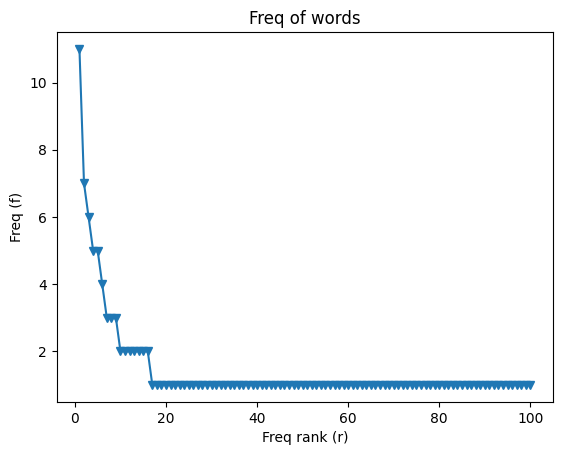

In [51]:
frequencies = get_frequencies(vocabulary, 100)
plot_frequencies(frequencies)

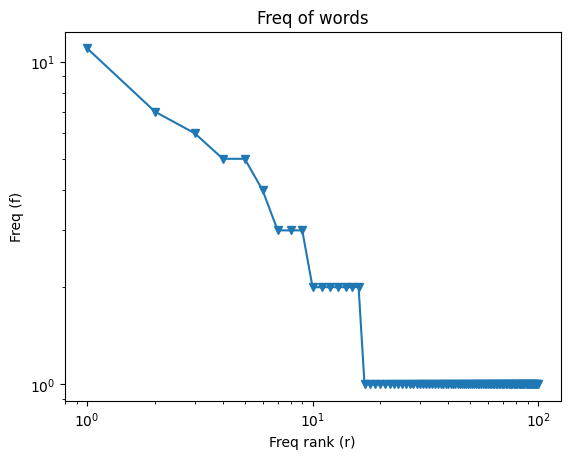

In [52]:
plot_frequencies(frequencies, log_scale=True)

**¿Qué pasará con más datos? 📊**

### Ley Zipf

Exploraremos el Corpus de Referencia del Español Actual [CREA](https://www.rae.es/banco-de-datos/crea/crea-anotado)

In [53]:
corpus_freqs = pd.read_csv("crea_frecs.txt", sep=" ")

In [54]:
corpus_freqs.head(15)

,freq,word
0,9999518,de
1,6277560,la
2,4681839,que
3,4569652,el
4,4234281,en
5,4180279,y
6,3260939,a
7,2618657,los
8,2022514,se
9,1857225,del


In [55]:
corpus_freqs.iloc[0]

freq    9999518
word         de
Name: 0, dtype: object

In [56]:
corpus_freqs[corpus_freqs["word"] == "barriga"]

,freq,word
12615,872,barriga


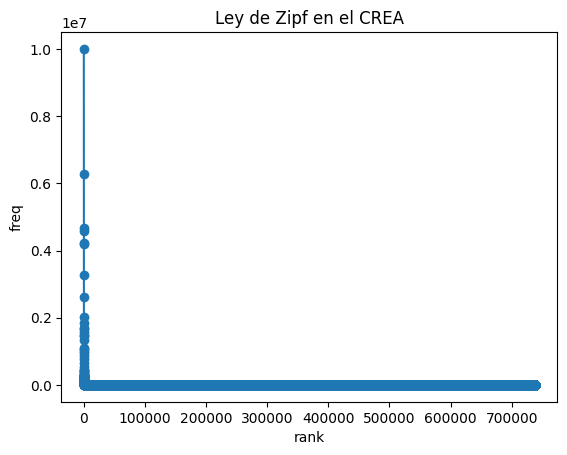

In [57]:
corpus_freqs["freq"].plot(marker="o")
plt.title('Ley de Zipf en el CREA')
plt.xlabel('rank')
plt.ylabel('freq')
plt.show()

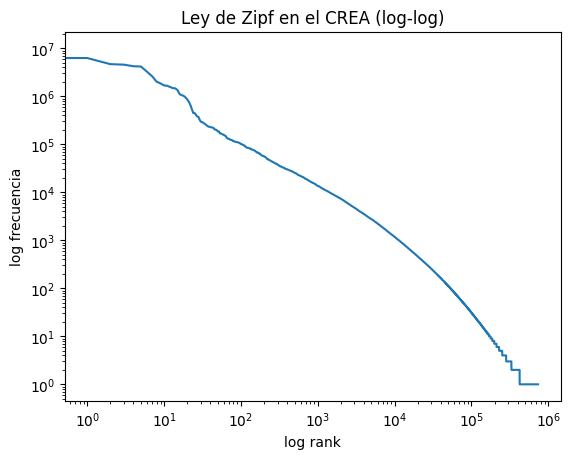

In [58]:
corpus_freqs['freq'].plot(loglog=True, legend=False)
plt.title('Ley de Zipf en el CREA (log-log)')
plt.xlabel('log rank')
plt.ylabel('log frecuencia')
plt.show()

- Notamos que las frecuencias entre lenguas siguen un patrón
- Pocas palabras (tipos) son muy frecuentes, mientras que la mayoría de palabras ocurren pocas veces

De hecho, la frecuencia de la palabra que ocupa la posición r en el rank, es proporcional a $\frac{1}{r}$ (La palabra más frecuente ocurrirá aproximadamente el doble de veces que la segunda palabra más frecuente en el corpus y tres veces más que la tercer palabra más frecuente del corpus, etc)

$$f(w_r) \propto \frac{1}{r^α}$$

Donde:
- $r$ es el rank que ocupa la palabra en el corpus
- $f(w_r)$ es la frecuencia de la palabra en el corpus
- $\alpha$ es un parámetro, el valor dependerá del corpus o fenómeno que estemos observando

#### Formulación de la Ley de Zipf:

$f(w_{r})=\frac{c}{r^{\alpha }}$

En la escala logarítimica:

$log(f(w_{r}))=log(\frac{c}{r^{\alpha }})$

$log(f(w_{r}))=log (c)-\alpha log (r)$

#### ❓ ¿Cómo estimar el parámetro $\alpha$?

Podemos hacer una regresión lineal minimizando la suma de los errores cuadráticos:

$J_{MSE}=\sum_{r}^{}(log(f(w_{r}))-(log(c)-\alpha log(r)))^{2}$

In [59]:
from scipy.optimize import minimize

ranks = np.array(corpus_freqs.index) + 1
frecs = np.array(corpus_freqs['freq'])

# Inicialización
a0 = 1

# Función de minimización:
func = lambda a: sum((np.log(frecs)-(np.log(frecs[0])-a*np.log(ranks)))**2)

# Apliando minimos cuadrados
a_hat = minimize(func, a0).x[0]

print('alpha:', a_hat, '\nMSE:', func(a_hat))

alpha: 1.1812227900048202 
MSE: 323481.1807174416


In [60]:
def plot_generate_zipf(alpha: np.float64, ranks: np.array, freqs: np.array) -> None:
    plt.plot(np.log(ranks),  np.log(freqs[0]) - alpha*np.log(ranks), color='r', label='Aproximación Zipf')

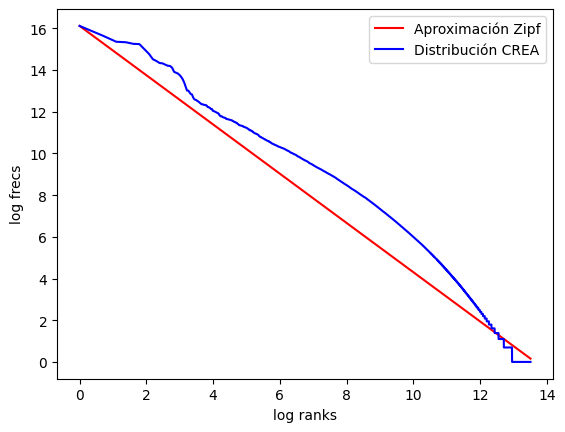

In [61]:
plot_generate_zipf(a_hat, ranks, frecs)
plt.plot(np.log(ranks),np.log(frecs), color='b', label='Distribución CREA')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Ley de Heap

Relación entre el número de **tokens** y **tipos** de un corpus

$$T \propto N^b$$

Dónde:

- $T = $ número de tipos
- $N = $ número de tokens
- $b = $ parámetro  

- **TOKENS**: Número total de palabras dentro del texto (incluidas repeticiones)
- **TIPOS**: Número total de palabras únicas en el texto

#### 📊 Ejercicio: Muestra el plot de tokens vs types para el corpus CREA

**HINT:** Obtener tipos y tokens acumulados

In [62]:
# PLOT tokens vs types
total_tokens = corpus_freqs["freq"].sum()
total_types = len(corpus_freqs)

In [63]:
corpus_sorted = corpus_freqs.sort_values(by="freq", ascending=False)
corpus_sorted["cum_tokens"] = corpus_sorted["freq"].cumsum()
corpus_sorted["cum_types"] = range(1, total_types +1)

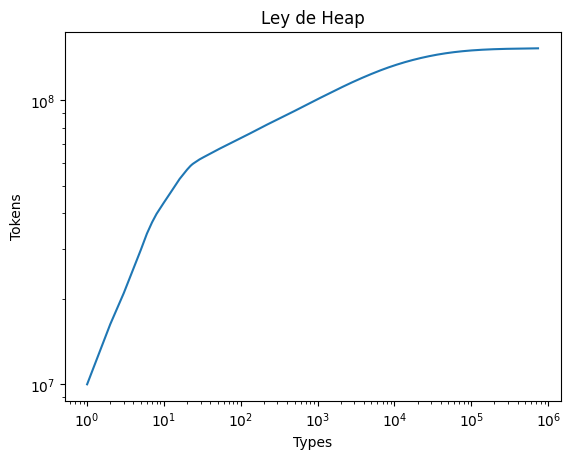

In [64]:
# Plot de la ley de Heap
plt.plot(corpus_sorted['cum_types'], corpus_sorted['cum_tokens'])
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Types')
plt.ylabel('Tokens')
plt.title('Ley de Heap')
plt.show()

### Representaciones vectoriales estáticas (estáticos)

- Buscamos una forma de mapear textos al **espacio vectorial**. Tener una representación numerica permite su procesamiento.
    - Similitud de docs
    - Clasificacion (agrupamiento)
- Veremos el enfoque de la Bolsa de Palabras (Bag of Words)
   - Matriz de documentos-terminos
   - Cada fila es un vector con $N$ features donde las features serán el vocabulario del corpus

<center>
<img src="https://preview.redd.it/sqkqsuit7o831.jpg?width=1024&auto=webp&s=2d18d38fe9d04a4a62c9a889e7b34ef14b425630" width=500></center>

In [65]:
import gensim

In [66]:
doc_1 = "Augusta Ada King, condesa de Lovelace (Londres, 10 de diciembre de 1815-íd., 27 de noviembre de 1852), registrada al nacer como Augusta Ada Byron y conocida habitualmente como Ada Lovelace, fue una matemática y escritora británica, célebre sobre todo por su trabajo acerca de la computadora mecánica de uso general de Charles Babbage, la denominada máquina analítica. Fue la primera en reconocer que la máquina tenía aplicaciones más allá del cálculo puro y en haber publicado lo que se reconoce hoy como el primer algoritmo destinado a ser procesado por una máquina, por lo que se le considera como la primera programadora de ordenadores."
doc_2 = "Brassica oleracea var. italica, el brócoli,1​ brécol2​ o bróquil3​ del italiano broccoli (brote), es una planta de la familia de las brasicáceas. Existen otras variedades de la misma especie, tales como: repollo (B. o. capitata), la coliflor (B. o. botrytis), el colinabo (B. o. gongylodes) y la col de Bruselas (B. o. gemmifera). El llamado brócoli chino o kai-lan (B. o. alboglabra) es también una variedad de Brassica oleracea."
doc_3 = "La bicicleta de piñón fijo, fixie o fixed es una bicicleta monomarcha, que no tiene piñón libre, lo que significa que no tiene punto muerto; es decir, los pedales están siempre en movimiento cuando la bicicleta está en marcha. Esto significa que no se puede dejar de pedalear, ya que, mientras la rueda trasera gire, la cadena y los pedales girarán siempre solidariamente. Por este motivo, se puede frenar haciendo una fuerza inversa al sentido de la marcha, y también ir marcha atrás."

In [67]:
documents = [doc_1, doc_2, doc_3]

In [68]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences: list[str]) -> list[list[str]]:
    """Function convert sentences to words

    Use the tokenizer provided by gensim using
    `simple_process()` which remove punctuation and converte
    to lowercase (`deacc=True`)
    """
    return [simple_preprocess(sent, deacc=True) for sent in sentences]

In [69]:
docs_tokenized = sent_to_words(documents)
docs_tokenized[0][:10]

['augusta',
 'ada',
 'king',
 'condesa',
 'de',
 'lovelace',
 'londres',
 'de',
 'diciembre',
 'de']

In [70]:
from gensim.corpora import Dictionary

gensim_dic = Dictionary()
bag_of_words_corpus = [gensim_dic.doc2bow(doc, allow_update=True) for doc in docs_tokenized]

In [71]:
type(gensim_dic)

gensim.corpora.dictionary.Dictionary

In [72]:
for k, v in gensim_dic.iteritems():
    print(k, v)

0 acerca
1 ada
2 al
3 algoritmo
4 alla
5 analitica
6 aplicaciones
7 augusta
8 babbage
9 britanica
10 byron
11 calculo
12 celebre
13 charles
14 como
15 computadora
16 condesa
17 conocida
18 considera
19 de
20 del
21 denominada
22 destinado
23 diciembre
24 el
25 en
26 escritora
27 fue
28 general
29 haber
30 habitualmente
31 hoy
32 id
33 king
34 la
35 le
36 lo
37 londres
38 lovelace
39 maquina
40 mas
41 matematica
42 mecanica
43 nacer
44 noviembre
45 ordenadores
46 por
47 primer
48 primera
49 procesado
50 programadora
51 publicado
52 puro
53 que
54 reconoce
55 reconocer
56 registrada
57 se
58 ser
59 sobre
60 su
61 tenia
62 todo
63 trabajo
64 una
65 uso
66 alboglabra
67 botrytis
68 brasicaceas
69 brassica
70 brecol
71 broccoli
72 brocoli
73 broquil
74 brote
75 bruselas
76 capitata
77 chino
78 col
79 coliflor
80 colinabo
81 es
82 especie
83 existen
84 familia
85 gemmifera
86 gongylodes
87 italiano
88 italica
89 kai
90 lan
91 las
92 llamado
93 misma
94 oleracea
95 otras
96 planta
97 repollo


In [73]:
print(len(bag_of_words_corpus))
bag_of_words_corpus[0]

3


[(0, 1),
 (1, 3),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 4),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 9),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 2),
 (26, 1),
 (27, 2),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 5),
 (35, 1),
 (36, 2),
 (37, 1),
 (38, 2),
 (39, 3),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 3),
 (47, 1),
 (48, 2),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 3),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 2),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 2),
 (65, 1)]

In [74]:
def bag_to_dict(bag_of_words: list, gensim_dic: Dictionary, titles: list[str]) -> list:
    data = {}
    for doc, title in zip(bag_of_words, titles):
        data[title] = dict([(gensim_dic[id], freq) for id, freq in doc])
    return data

In [75]:
data = bag_to_dict(bag_of_words_corpus, gensim_dic, titles=["ADA", "BROCOLI", "FIXED"])

In [76]:
data

{'ADA': {'acerca': 1,
  'ada': 3,
  'al': 1,
  'algoritmo': 1,
  'alla': 1,
  'analitica': 1,
  'aplicaciones': 1,
  'augusta': 2,
  'babbage': 1,
  'britanica': 1,
  'byron': 1,
  'calculo': 1,
  'celebre': 1,
  'charles': 1,
  'como': 4,
  'computadora': 1,
  'condesa': 1,
  'conocida': 1,
  'considera': 1,
  'de': 9,
  'del': 1,
  'denominada': 1,
  'destinado': 1,
  'diciembre': 1,
  'el': 1,
  'en': 2,
  'escritora': 1,
  'fue': 2,
  'general': 1,
  'haber': 1,
  'habitualmente': 1,
  'hoy': 1,
  'id': 1,
  'king': 1,
  'la': 5,
  'le': 1,
  'lo': 2,
  'londres': 1,
  'lovelace': 2,
  'maquina': 3,
  'mas': 1,
  'matematica': 1,
  'mecanica': 1,
  'nacer': 1,
  'noviembre': 1,
  'ordenadores': 1,
  'por': 3,
  'primer': 1,
  'primera': 2,
  'procesado': 1,
  'programadora': 1,
  'publicado': 1,
  'puro': 1,
  'que': 3,
  'reconoce': 1,
  'reconocer': 1,
  'registrada': 1,
  'se': 2,
  'ser': 1,
  'sobre': 1,
  'su': 1,
  'tenia': 1,
  'todo': 1,
  'trabajo': 1,
  'una': 2,
  'uso'

In [77]:
import pandas as pd

doc_matrix_simple = pd.DataFrame(data).fillna(0).astype(int).T

In [78]:
doc_matrix_simple

,acerca,ada,al,algoritmo,alla,analitica,aplicaciones,augusta,babbage,britanica,...,puede,punto,rueda,sentido,siempre,significa,solidariamente,tiene,trasera,ya
ADA,1,3,1,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
BROCOLI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIXED,0,0,1,0,0,0,0,0,0,0,...,2,1,1,1,2,2,1,2,1,1


- Tenemos una matrix de terminos-frecuencias ($tf$). Es decir cuantas veces un termino aparece en cierto documento.
- Una variante de esta es una **BoW** binaria. ¿Cómo se vería?


**¿Ven algun problema?**

- Palabras muy frecuentes que no aportan signifiancia
- Los pesos de las palabras son tratados de forma equitativa
    - Palabras muy frecuentes opacan las menos frecuentes y con mayor significado (semántico) en nuestros documentos
- Las palabras frecuentes no nos ayudarian a discriminar por ejemplo entre documentos

#### *Term frequency-Inverse Document Frequency* (TF-IDF) al rescate

<center><img src="https://media.tenor.com/Hqyg8s_gh5QAAAAd/perfectly-balanced-thanos.gif" height=250></center>

- Metodo de ponderación creado para algoritmos de Information Retrieval
- Bueno para clasificación de documentos y clustering
- Se calcula con la multiplicacion $tf_{d,t} \cdot idf_t$

Donde:
  - $tf_{d,t}$ es la frecuencia del termino en un documento $d$
  - $idf_t$ es la frecuencia inversa del termino en toda la colección de documentos. Se calcula de la siguiente forma:

$$idf_t = log_2\frac{N}{df_t}$$

Entonces:

$$tf\_idf(d,t) = tf_{d,t} ⋅ \log_2\frac{N}{df_t}$$

#### 🧮 Ejercicio: Aplica TF-IDF usando gensim

**HINT:** https://radimrehurek.com/gensim/models/tfidfmodel.html

In [79]:
from gensim.models import TfidfModel

tfidf = TfidfModel(bag_of_words_corpus, smartirs="ntc")

In [80]:
tfidf[bag_of_words_corpus[0]]

[(0, 0.10051035884473423),
 (1, 0.3015310765342027),
 (2, 0.05025517942236712),
 (3, 0.10051035884473423),
 (4, 0.10051035884473423),
 (5, 0.10051035884473423),
 (6, 0.10051035884473423),
 (7, 0.20102071768946847),
 (8, 0.10051035884473423),
 (9, 0.10051035884473423),
 (10, 0.10051035884473423),
 (11, 0.10051035884473423),
 (12, 0.10051035884473423),
 (13, 0.10051035884473423),
 (14, 0.20102071768946847),
 (15, 0.10051035884473423),
 (16, 0.10051035884473423),
 (17, 0.10051035884473423),
 (18, 0.10051035884473423),
 (19, 0.1877200559394197),
 (20, 0.05025517942236712),
 (21, 0.10051035884473423),
 (22, 0.10051035884473423),
 (23, 0.10051035884473423),
 (24, 0.05025517942236712),
 (25, 0.10051035884473423),
 (26, 0.10051035884473423),
 (27, 0.20102071768946847),
 (28, 0.10051035884473423),
 (29, 0.10051035884473423),
 (30, 0.10051035884473423),
 (31, 0.10051035884473423),
 (32, 0.10051035884473423),
 (33, 0.10051035884473423),
 (34, 0.10428891996634428),
 (35, 0.10051035884473423),
 (36

In [81]:
def bag_to_dict_tfidf(bag_of_words: list, gensim_dic: Dictionary, titles: list[str]) -> list:
    data = {}
    tfidf = TfidfModel(bag_of_words, smartirs="ntc")
    for doc, title in zip(tfidf[bag_of_words], titles):
        data[title] = dict([(gensim_dic[id], freq) for id, freq in doc])
    return data

In [82]:
data = bag_to_dict_tfidf(bag_of_words_corpus, gensim_dic, titles=["ADA", "BROCOLI", "FIXED"])

In [83]:
data

{'ADA': {'acerca': 0.10051035884473423,
  'ada': 0.3015310765342027,
  'al': 0.05025517942236712,
  'algoritmo': 0.10051035884473423,
  'alla': 0.10051035884473423,
  'analitica': 0.10051035884473423,
  'aplicaciones': 0.10051035884473423,
  'augusta': 0.20102071768946847,
  'babbage': 0.10051035884473423,
  'britanica': 0.10051035884473423,
  'byron': 0.10051035884473423,
  'calculo': 0.10051035884473423,
  'celebre': 0.10051035884473423,
  'charles': 0.10051035884473423,
  'como': 0.20102071768946847,
  'computadora': 0.10051035884473423,
  'condesa': 0.10051035884473423,
  'conocida': 0.10051035884473423,
  'considera': 0.10051035884473423,
  'de': 0.1877200559394197,
  'del': 0.05025517942236712,
  'denominada': 0.10051035884473423,
  'destinado': 0.10051035884473423,
  'diciembre': 0.10051035884473423,
  'el': 0.05025517942236712,
  'en': 0.10051035884473423,
  'escritora': 0.10051035884473423,
  'fue': 0.20102071768946847,
  'general': 0.10051035884473423,
  'haber': 0.1005103588

In [84]:
doc_matrix_tfidf = pd.DataFrame(data).fillna(0).T

In [85]:
doc_matrix_tfidf

,acerca,ada,al,algoritmo,alla,analitica,aplicaciones,augusta,babbage,britanica,...,puede,punto,rueda,sentido,siempre,significa,solidariamente,tiene,trasera,ya
ADA,0.10051,0.301531,0.050255,0.10051,0.10051,0.10051,0.10051,0.201021,0.10051,0.10051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BROCOLI,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FIXED,0.00000,0.000000,0.050281,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.201123,0.100561,0.100561,0.100561,0.201123,0.201123,0.100561,0.201123,0.100561,0.100561


#### Calculando similitud entre vectores

<center><img src="https://cdn.acidcow.com/pics/20130320/people_who_came_face_to_face_with_their_doppelganger_19.jpg" width=500></center>

La forma estandar de obtener la similitud entre vectores para **BoW** es con la distancia coseno entre ellos

$$cos(\overrightarrow{v},\overrightarrow{w}) = \frac{\overrightarrow{v} \cdot\overrightarrow{w}}{|\overrightarrow{v}||\overrightarrow{w}|}$$

Aunque hay muchas más formas de [calcular la distancia](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) entre vectores

In [86]:
from sklearn.metrics.pairwise import cosine_similarity

doc_1 = doc_matrix_tfidf.loc["BROCOLI"].values.reshape(1, -1)
doc_2 = doc_matrix_tfidf.loc["FIXED"].values.reshape(1, -1)
cosine_similarity(doc_1, doc_2)

array([[0.04168787]])

#### Agregando más documentos a nuestra bolsa

![](https://media.tenor.com/55hA4TgUrOMAAAAM/bag-bags.gif)

In [87]:
def update_bow(doc: str, bag_of_words: list, gensim_dic: Dictionary) -> pd.DataFrame:
    words = simple_preprocess(doc, deacc=True)
    bag_of_words.append(gensim_dic.doc2bow(words, allow_update=True))
    return bag_of_words

In [88]:
#sample_doc = "Las bicicletas fixie, también denominadas bicicletas de piñón fijo, son bicis de una sola marcha, de piñón fijo, y sin punto muerto, por lo que se debe avanzar, frenar y dar marcha atrás con el uso de los pedales. La rueda de atrás gira cuando giran los pedales. Si pedaleas hacia delante, avanzas; si paras los pedales, frenas y si pedaleas hacia atrás, irás marcha atrás. Esto requiere de un entrenamiento añadido que la bicicleta con piñón libre no lo necesita. No obstante, las bicicletas fixie tienen muchísimas ventajas."
sample_doc = "El brócoli o brécol es una planta de la familia de las brasicáceas, como otras hortalizas que conocemos como coles. Está por tanto emparentado con verduras como la coliflor, el repollo y las diferentes coles lisas o rizadas, incluyendo el kale o las coles de Bruselas."

In [89]:
new_bag = update_bow(sample_doc, bag_of_words_corpus.copy(), gensim_dic)
len(new_bag)

4

In [90]:
for k, v in gensim_dic.iteritems():
    print(k, v)

0 acerca
1 ada
2 al
3 algoritmo
4 alla
5 analitica
6 aplicaciones
7 augusta
8 babbage
9 britanica
10 byron
11 calculo
12 celebre
13 charles
14 como
15 computadora
16 condesa
17 conocida
18 considera
19 de
20 del
21 denominada
22 destinado
23 diciembre
24 el
25 en
26 escritora
27 fue
28 general
29 haber
30 habitualmente
31 hoy
32 id
33 king
34 la
35 le
36 lo
37 londres
38 lovelace
39 maquina
40 mas
41 matematica
42 mecanica
43 nacer
44 noviembre
45 ordenadores
46 por
47 primer
48 primera
49 procesado
50 programadora
51 publicado
52 puro
53 que
54 reconoce
55 reconocer
56 registrada
57 se
58 ser
59 sobre
60 su
61 tenia
62 todo
63 trabajo
64 una
65 uso
66 alboglabra
67 botrytis
68 brasicaceas
69 brassica
70 brecol
71 broccoli
72 brocoli
73 broquil
74 brote
75 bruselas
76 capitata
77 chino
78 col
79 coliflor
80 colinabo
81 es
82 especie
83 existen
84 familia
85 gemmifera
86 gongylodes
87 italiano
88 italica
89 kai
90 lan
91 las
92 llamado
93 misma
94 oleracea
95 otras
96 planta
97 repollo


In [91]:
new_data = bag_to_dict_tfidf(new_bag, gensim_dic, ["ADA", "BROCOLI", "FIXED", "SAMPLE"])

In [92]:
new_doc_matrix_tfidf = pd.DataFrame(new_data).fillna(0).T
new_doc_matrix_tfidf

,acerca,ada,al,algoritmo,alla,analitica,aplicaciones,augusta,babbage,britanica,...,conocemos,diferentes,emparentado,hortalizas,incluyendo,kale,lisas,rizadas,tanto,verduras
ADA,0.104156,0.312469,0.059299,0.104156,0.104156,0.104156,0.104156,0.208313,0.104156,0.104156,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BROCOLI,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FIXED,0.000000,0.000000,0.058833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMPLE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.187176,0.187176,0.187176,0.187176,0.187176,0.187176,0.187176,0.187176,0.187176,0.187176


#### 👯‍♂️ Ejercicio: Calcula la similitud del nuevo documento con el resto de documentos

In [93]:
doc_sample_values = new_doc_matrix_tfidf.loc["SAMPLE"].values.reshape(1, -1)

doc_titles = ["ADA", "BROCOLI", "FIXED"]
for i, doc_title in enumerate(doc_titles):
    current_doc_values = new_doc_matrix_tfidf.loc[doc_title].values.reshape(1, -1)
    print(f"Similarity beetwen SAMPLE/{doc_title}= {cosine_similarity(current_doc_values, doc_sample_values)}")

Similarity beetwen SAMPLE/ADA= [[0.05585885]]
Similarity beetwen SAMPLE/BROCOLI= [[0.18502544]]
Similarity beetwen SAMPLE/FIXED= [[0.02966609]]


## Práctica 2: Propiedades estadísticas de la lengua

### Fecha de entrega: 2 de Marzo de 2025 11:59pm

1. Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.
    - *Ejemplo:* Un "lenguaje artificial" podría ser simplemente un texto donde las secuencias de caracteres fueron generadas aleatoriamente.


In [94]:
def generate_word(length: int) -> str:
    """
    Generate a random word.
    Parameters:
      length: The length of the word to generate.
      seed: The seed to use for the random number generator.
    Returns:
      A string with the generated word.
    """
    vowels = "aeiou"
    consonants = "bcdfghjklmnpqrstvwxyz"
    probs_num_cons = [0.45, 0.3, 0.15, 0.1]
    probs_num_vow = [0.55, 0.3, 0.15]
    prob_begin_vowel = 0.5

    word = ""
    next_vowel = False
    if np.random.rand() < prob_begin_vowel:
        num_vow = np.random.choice([1, 2, 3], p=probs_num_vow)
        for _ in range(num_vow):
            word += random.choice(vowels)
    else:
        num_cons = np.random.choice([1, 2, 3, 4], p=probs_num_cons)
        for _ in range(num_cons):
            word += random.choice(consonants)
        next_vowel = True

    while len(word) < length:
        if next_vowel:
            num_vow = np.random.choice([1, 2, 3], p=probs_num_vow)
            for _ in range(num_vow):
                word += random.choice(vowels)
            next_vowel = False
        else:
            num_cons = np.random.choice([1, 2, 3, 4], p=probs_num_cons)
            for _ in range(num_cons):
                word += random.choice(consonants)
            next_vowel = True

    if length < len(word):
        word = word[:length]
    return word

In [95]:
def generate_text(length: int, matrix_transition: np.ndarray, seed: int = 42) -> str:
    """
    Generate a text with random characters.
    Parameters:
      length: The length of the text to generate.
      seed: The seed to use for the random number generator.
    Returns:
      A string with the generated text.
    """
    text = []
    length_ = np.random.poisson(3)
    if length_ < 1 or length_ > 25:
        length_ = 3
    text.append(generate_word(length_))
    while len(text) < length:
        probs_next_length = matrix_transition[length_-1]
        length_ = np.random.choice(range(1, matrix_transition.shape[0]+1), p=probs_next_length)
        text.append(generate_word(length_))

    return text

In [96]:
# Definir los estados: Longitudes de palabra de 1 a 25
max_length = 25
states = np.arange(1, max_length + 1)

# Crear una distribución inicial que favorezca palabras cortas (usando una distribución inversa)
initial_distribution = 1 / states  # Más peso a palabras cortas
initial_distribution /= initial_distribution.sum()  # Normalizar

# Matriz de transición: Probabilidad de ir de una longitud a otra
transition_matrix = np.zeros((max_length, max_length))

# Construir la matriz con mayor probabilidad de transiciones cercanas
for i in range(max_length):
    for j in range(max_length):
        distancia = abs(states[i] - states[j])
        transition_matrix[i, j] = np.exp(-0.5 * distancia)  # Penalizar saltos grandes

    # Favorecer la longitud actual y normalizar la fila
    transition_matrix[i] *= initial_distribution[i]
    transition_matrix[i] /= transition_matrix[i].sum()

In [97]:
text = pd.Series(generate_text(100000, transition_matrix))

In [98]:
words_counts = text.value_counts()

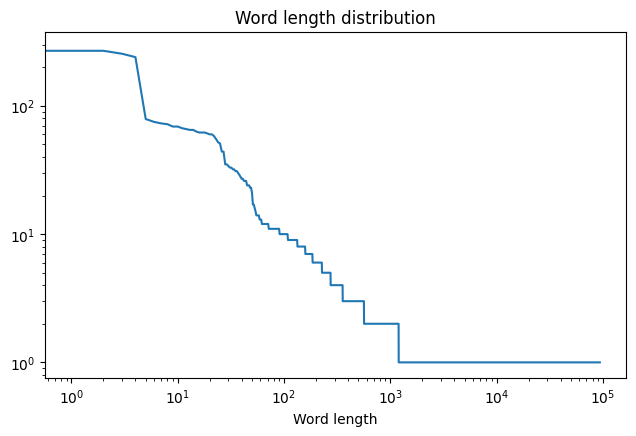

In [99]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(words_counts.index, words_counts.values)
plt.xlabel('Word length')
plt.xscale('log')
plt.yscale('log')
plt.title('Word length distribution')
plt.show()

Podemos ver cómo las frecuencias de las palabras siguen un comportamiento similar a la Ley de Zipf, esto se debe a cómo se construyo el lenguaje, si bien se usan caracteres aleatorios, para la construcción de las palabras se consideró la secuencia CVCV consonante - vocal / vocal - consonante para cosntruirlas considerando probabilidades altas para secuencias monovocálicas, un poco menos para diptongos y poco menos para triptongos; para las secuencias de consonantes se consideran también probabilidades altas para solo una consonante y bajan gradualmente hasta secuencias de cuatro vocales.

Por otro lado, se consideró tmabién una matriz de transicion entre palabras modelando con una Cadena de Markov las secuencias de las longitudes de palabras, priorizando las palabras cortas y dando una probabilidad más baja de transicionar a palabras largas, con esto logramos replicar un comportamiento similar a la Ley Zipf

2. Explorar `datasets` del sitio [Hugging Face](https://huggingface.co/datasets) y elegir documentos de diferentes dominios en Español (al menos 3). Realizar reconocimiento de entidades nombradas (NER).
    - Pueden utilizar subconjuntos de los datasets encontrados
    - Mostrar resultados del reconocimiento
    - Una distribución de frecuencias de las etiquetas más comunes en cada dominio
    - Comentarios generales del desempeño observado.

*Sugerencias: Spacy, CoreNLP (puede ser cualquier otra herramienta)*

In [100]:
ds1 = load_dataset("Fernandoefg/cuentos_es")
ds2 = load_dataset("dariolopez/justicio-BOE-A-1978-31229-constitucion-by-articles")
ds3 = load_dataset("Angy309/Noticias")

c:\Users\david\miniconda3\envs\PLN\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--Fernandoefg--cuentos_es. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|█████████████████████████████████████████████| 7239/7239 [00:05<00:00, 1397.95 e

In [101]:
subset1 = [ds1['train'].data['content'][i].as_py() for i in range(5)]
subset2 = [ds2['train'].data['text'][i].as_py() for i in range(5)]
subset3 = [ds3['test'].data['text'][i].as_py() for i in range(15)]

In [102]:
docs1 = list(nlp.pipe(subset1))
docs2 = list(nlp.pipe(subset2))
docs3 = list(nlp.pipe(subset3))

In [103]:
displacy.render(docs1[0][:500], style="ent")

In [104]:
displacy.render(docs2, style="ent")

In [105]:
displacy.render(docs3, style="ent")

Se utilizaron tres corpus diferentes; uno de cuentos, uno de leyes del gobierno de España y otro de noticias. Se utilizó Spacy junto con su corpus de noticias en Español para identificar las entidades nombrada. Se pude observar que para el cuento, Spacy no hace un buen trabajo, en particular la etiqueta ORG (Organización) se utiliza de manera incorrecta y en general el desempeño es bastante malo ya que los cuentos al ser un lenguaje más narrativo y descriptivo hacen poco uso de entidades nombradas.

Para el texto de las leyes de España mejora el reconocimiento de la etiqueta PERSON esto puede deberse a que en este tipo de textos estas entidades suelen aparecer de forma muy clara para ser preciso en cuanto al lenguaje jurídico, para saber en quien recae la acción y la responsabilidad.

Finalmente, en el corpus de noticias, la identificación fue mucho más precisa y en general fue donde el desempeño resultó el mejor de entre los tres; esto se debe a que es en este tipo de textos en los que Spicy fue entrenado con su corpus de noticias en Español.